In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sentiment Analysis

Based on: https://www.nickmccullum.com/stock-market-sentiment-analysis-python/

- Sentiment analysis, also known as opinion mining, is a natural language processing technique (NLP) used to establish whether data is positive, neutral, or negative.
- When it comes to the stock market, you can use sentiment analysis to analyze news headlines about a particular stock. From this, you can tell whether the price of a stock is headed in a positive or a negative direction. we will be extracting stock sentiments from FinViz website using Python. We will be targeting the headlines of the financial news that are published on the website.

Libraries needed:

- BeautifulSoup - to parse data from the website
- urllib (requests) library to get the data
- nltk.sentiment.vader library to perform sentiment analysis on the news headlines. Here NLTK stands for Natural Language Toolkit.

#### Importing Data

In [4]:
import os
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

- To parse the website, you should add the stock ticker to the end of the following URL: https://finviz.com/quote.ashx?t=
- We will extract and store the date, the time, and the news headlines data. For this, as for other web-scrapping tasks, one needs to inspect the HTML code for the news headline section. In our case, the code shows that the news have been stored in a table with id=news-table. Each news headline has been put in its own row using the $\langle$tr$\rangle$ and $\langle$/tr$\rangle$ tags.
- The date and time data has been nested within the $\langle$td$\rangle$ and $\langle$/td$\rangle$ tags, while the news headline text has been nested between $\langle$a$\rangle$ and $\langle$/a$\rangle$ tags.
- Our goal is to extract the date, time, and news headline per row and perform sentiment analysis on the news headline. We now want to extract the entire news table for three stocks, say Amazon (AMZN), Google (GOOG), and Tesla (TSLA).

The data will be stored in a Python dictionary, as done below:


In [5]:
web_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}
tickers = ['AMZN', 'GOOG', 'TSLA']

for tick in tickers:
    url = web_url + tick # stock url
    req = Request(url=url,headers={"User-Agent": "Chrome"})  
    response = urlopen(req)    
    html = BeautifulSoup(response,"html.parser")
    news_table = html.find(id='news-table') # extract data
    news_tables[tick] = news_table

- We now have a dictionary named news_data with all data, in HTML format, including the HTML tags.
- We extract news headlines from the a tags, and dates from the td tags.

Below we print the first 4 headlines:

In [8]:
amazon = news_tables['AMZN']
amazon_tr = amazon.findAll('tr')

for x, table_row in enumerate(amazon_tr):
    a_text = table_row.a.text
    td_text = table_row.td.text
    print(a_text)
    print(td_text)
    if x == 3:
        break

With 59% ownership of the shares, Amazon.com, Inc. (NASDAQ:AMZN) is heavily dominated by institutional owners
Apr-26-23 07:01AM
Heres Why Polen Capital Focus Growth Strategy Sold Dollar General Corporation (DG)
05:42AM
Down 20% to 46%, These Colossal Growth Stocks Could Be Ready for a Surge
05:25AM
Microsoft Q3 earnings: Despite cloud struggles, tech giant beat on revenue and EPS
Apr-25-23 04:06PM


- We now want to write some code to parse the date, the time, and the headlines into a Python List called news_list.
- A closer look at the news headlines reveals that only the first news of each day has the date label. To account for this, we will use an if statement.

In [9]:
news_list = []

for file_name, news_table in news_tables.items(): # iterate over news
    for i in news_table.findAll('tr'): # iterate over  <tr> tags
        
        text = i.a.get_text() # extract text within <tr> tag that has the <a> tag
        date_scrape = i.td.text.split() # extract and split into a list the text within <td> tag

        if len(date_scrape) == 1:
            time = date_scrape[0] # time will be loaded as the only element.
            
        else:
            date = date_scrape[0] # date will be loaded as the first element 
            time = date_scrape[1] # and time as the second

        tick = file_name.split('_')[0]
        
        news_list.append([tick, date, time, text])

In [16]:
news_list[10]

['AMZN',
 'Apr-25-23',
 '12:30PM',
 'Love Reading? Get Your Free Kindle Book Today']

#### Sentiment Analysis (nltk.sentiment.vader)

We can now use nltk.sentiment.vader to perform sentiment analysis. We will first store the ticker, the date, the time, and the headlines in a DataFrame. Next, we will perform sentiment analysis on the headlines and then add an additional column to our DataFrame to store the sentiment scores per headline:

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# might need to download extra stuff:
# import nltk
# nltk.download('vader_lexicon')

In [20]:
vader = SentimentIntensityAnalyzer()

columns = ['ticker', 'date', 'time', 'headline']
news_df = pd.DataFrame(news_list, columns=columns)

# Sentiment Scores
scores = news_df['headline'].apply(vader.polarity_scores).tolist()

scores_df = pd.DataFrame(scores)
news_df = news_df.join(scores_df, rsuffix='_right')
news_df['date'] = pd.to_datetime(news_df.date).dt.date

news_df.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2023-04-26,07:01AM,"With 59% ownership of the shares, Amazon.com, ...",0.0,0.864,0.136,0.2960
1,AMZN,2023-04-26,05:42AM,Heres Why Polen Capital Focus Growth Strategy ...,0.0,0.809,0.191,0.3818
2,AMZN,2023-04-26,05:25AM,"Down 20% to 46%, These Colossal Growth Stocks ...",0.0,0.683,0.317,0.6249
3,AMZN,2023-04-25,04:06PM,Microsoft Q3 earnings: Despite cloud struggles...,0.0,0.850,0.150,0.2755
4,AMZN,2023-04-25,03:52PM,Everything You Need to Know About Amazon's Upc...,0.0,1.000,0.000,0.0000


So what are we actually doing here? See: https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

- Why is Sentiment Analysis difficult to perform? Though it may seem easy on paper, Sentiment Analysis is a tricky subject. A text may contain multiple sentiments all at once.
- VADER (Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.
- VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.

For example - Words like 'love', 'enjoy', 'happy', 'like' all convey a positive sentiment. Also VADER is intelligent enough to understand the basic context of these words, such as 'did not love' as a negative statement. It also understands the emphasis of capitalization and punctuation, such as 'ENJOY'.

NOTE 1: We’re not trying to guess how many stars a reviewer awarded, just whether the review was positive or negative.

NOTE 2: A model trained on paragraph-long reviews might not be effective. 



- The nltk.sentiment.vaed lexicon can be used for a variety of datasets, like amazon reviews, movie reviews, or any other reviews for any product.
- VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of four categories: NEGATIVE, NEUTRAL, POSITIVE, COMPOUND, with the latter being computed by normalizing the scores of the previous 3.
- Let us analyze some random statements through our sentimental analyzer:


In [25]:
sid = SentimentIntensityAnalyzer()

a = 'This was a good movie.'
print(sid.polarity_scores(a))

a = 'This was the best, most awesome movie EVER MADE!!!'
print(sid.polarity_scores(a))

a = 'This movie was utter dogshit!'
print(sid.polarity_scores(a))

a = 'This movie was as good as a piece of wood.' # sarcasm not very well detected
print(sid.polarity_scores(a))

a = 'It cannot get better than this!' # having some issues detecting this as well
print(sid.polarity_scores(a))

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.8877}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'compound': 0.4404}
{'neg': 0.35, 'neu': 0.65, 'pos': 0.0, 'compound': -0.4015}


- Let us return to our stocks. The compound column gives us the sentiment scores. A higher positive value is an indication that the sentiment is more positive. A more negative value is an indication that the sentiment is more negative.
- The scores should range between -1 and 1.

We can now plot a bar chart that visualizes the sentiment score for each day.

Let's create a code that takes the average of the sentiment scores for all the news headlines collected during each date and visualize it on a bar chart. 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11096\1048971057.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = news_df.groupby(['ticker','date']).mean()


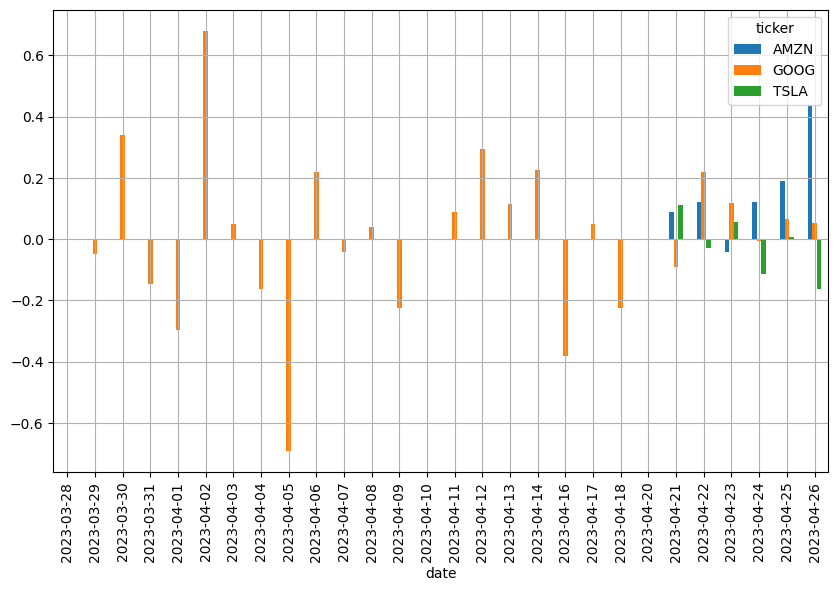

In [26]:
plt.rcParams['figure.figsize'] = [10, 6]

mean_scores = news_df.groupby(['ticker','date']).mean() # group elements by columns 'ticker' and 'date'
# this achieves a mean of the scores per day (as day is specified by date), for each ticker

# The unstack method returns a DataFrame having a new level of column labels 
# whose inner-most level consists of the pivoted index labels.
# here: date and tickers
mean_scores = mean_scores.unstack() 
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

mean_scores.plot(kind = 'bar')

plt.grid()
plt.show()

# NLP for 10-k forms

Based on: https://towardsdatascience.com/nlp-in-the-stock-market-8760d062eb92

- Natural language processing (NLP) enables us to analyze financial documents such as 10-k forms to forecast stock movements. A Form 10-K is an annual report required by the U.S. Securities and Exchange Commission (SEC), that gives a comprehensive summary of a company's financial performance. The 10-K includes information such as company history, organizational structure, executive compensation, equity, subsidiaries, and audited financial statements, among other information, and is usually slightly different from the "annual report to shareholders".

#### NLP Explained

- Natural language processing is a branch of artificial intelligence concerned with teaching computers to read and derive meaning from language. Since language is so complex, computers have to be taken through a series of steps before they can comprehend text. The following is a quick explanation of the steps that appear in a typical NLP pipeline:
1. Sentence Segmentation: The text document is segmented into individual sentences.
2. Tokenization: Once the document is broken into sentences, we further split the sentences into individual words. Each word is called a token, hence the name tokenization.
3. Parts-of-Speech-Tagging: We input each token as well as a few words around it into a pre trained part-of-speech classification model to receive the part-of-speech for the token as an output.
4. Lemmatization: Words often appear in different forms while referring to the same object/action. To prevent the computer from thinking of different forms of a word as different words, we perform lemmatization, the process of grouping together various inflections of a word to analyze them as a single item, identified by the word’s lemma (how the word appears in the dictionary).
5. Stop Words: Extremely common words such as “and”, “the” and “a” don’t provide any value, so we identify them as stop words to exclude them from any analysis performed on the text.
6. Dependency Parsing: Assign a syntactic structure to sentences and make sense of how the words in the sentence relate to each other by feeding the words to a dependency parser.
7. Noun Phrases: Grouping the noun phrases in a sentence together can help simplify sentences for cases when we don’t care about adjectives.
8. Named Entity Recognition: A Named Entity Recognition model can tag objects such as people’s names, company names, and geographic locations.
9. Coreference Resolution: Since NLP models analyze individual sentences, they become confused by pronouns referring to nouns from other sentences. To solve this problem, we employ coreference resolution which tracks pronouns across sentences to avoid confusion.

Four our purposes, see https://github.com/roshan-adusumilli/nlp_10-ks full github repository. There are some utility functions inside project_helper and project_tests that we will use.

In [10]:
import nltk
import pickle
import pprint
from tqdm import tqdm

In [13]:
import sys
sys.path.append("C:/Users/Administrator/Desktop/ML projects/Stock Sentiment")

import project_helper

Then we download the stopwords corpus for removing stopwords and wordnet corpus for lemmatizing.

In [14]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...


True

10-k documents include information such as company history, organizational structure, executive compensation, equity, subsidiaries, and audited financial statements. To lookup 10-k documents, we use each company’s unique CIK (Central Index Key).

We pull a list of filed 10-ks from the SEC and display Amazon data as an example.

In [15]:
from bs4 import BeautifulSoup

cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'CVX': '0000093410',
    'FL': '0000850209',
    'FRT': '0000034903',
    'HON': '0000773840'}

sec_api = project_helper.SecAPI()

def get_sec_data(cik, doc_type, start=0, count=60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [(
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)]
    return entries


In [16]:
example_ticker = 'AMZN'
sec_data = {}
for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')
    
pprint.pprint(sec_data[example_ticker][:5])

UnicodeEncodeError: 'ascii' codec can't encode characters in position 2599-2601: ordinal not in range(128)